In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from datafold.appfold import EDMD
from datafold.pcfold import PCManifold, InverseMultiquadricKernel, TSCDataFrame
from datafold.pcfold.kernels import RadialBasisKernel, _apply_kernel_function_numexpr
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCRadialBasis

## Inverted pendulum Physics

In [4]:
class InvertedPendulum:
    def __init__(self, 
                # Pendulum parameters
                pendulum_mass      = .0905, # kgg
                cart_mass          = 1.12,  # k
                g                  = 9.81,  # m/s^2
                tension_force_gain = 7.5,   # -
                pendulum_length    = .365,  # m
                cart_friction      = 6.65): # -
        self.pendulum_mass      = pendulum_mass     
        self.cart_mass          = cart_mass         
        self.g                  = g                 
        self.tension_force_gain = tension_force_gain
        self.pendulum_length    = pendulum_length   
        self.cart_friction      = cart_friction
        self.reset()
    
    def reset(self):
        self.state = np.array([[0, 0, np.pi, 0]])
        self.last_time = 0
    
    def _f(self, t, state, control_input):
        # inverted pendulum physics
        x, xdot, theta, thetadot = state
        f1 = xdot
        f3 = thetadot
        # Sabin version - math error or coding error?
        #f4 = ((self.cart_mass + self.pendulum_mass)*self.g*np.sin(theta) 
        #      + self.cart_friction*np.cos(theta)*xdot
        #      - self.pendulum_mass*self.pendulum_length*thetadot**2*np.sin(theta)*np.cos(theta)) \
        #     / (self.pendulum_length*(self.cart_mass+self.pendulum_mass*np.sin(theta)**2))
        #f2 = (self.tension_force_gain*control_input 
        #      - self.cart_friction*xdot 
        #      - self.pendulum_mass*self.pendulum_length*f4**2*np.sin(theta)
        #      - self.pendulum_mass*self.g*np.cos(theta)*np.sin(theta)) \
        #     / (self.cart_mass+self.pendulum_mass*np.sin(theta)**2)
        # Sabin Ref.[16] version
        f2 = (self.tension_force_gain*control_input
              - self.cart_friction*xdot
              - self.pendulum_mass*self.pendulum_length*thetadot**2*np.sin(theta)) \
             /(self.cart_mass + self.pendulum_mass*np.sin(theta)**2)
        f4 = (self.tension_force_gain*control_input
              - self.cart_friction*xdot
              - self.pendulum_mass*self.pendulum_length*thetadot**2*np.sin(theta)*np.cos(theta)
              + (self.cart_mass + self.pendulum_mass)*self.g*np.sin(theta)) \
             /(self.pendulum_length - self.pendulum_mass*self.pendulum_length*np.cos(theta)**2)
        return np.array((f1, f2, f3, f4))
    
    def _check_state(self, state):
        if state is None:
            # use last state if none given
            state = self.state
        else:
            # make sure state is the right shape
            try:
                state = state.reshape(4,1)
            except ValueError as e:
                 raise ValueError('State should have size 4.') from e
        return state
    
    def step(self, time_step, state = None, control_input = 0, current_time = None):
        '''
        Return the next state
        
        time_step - length of single time step
        state - state to step from (default last state of the pendulum)
        control_input - applied control force (default 0)
        current_time - time to step from (default last time of the pendulum)
        '''
        state = self._check_state(state)
        t0 = self.last_time if current_time is None else current_time
        self.sol = solve_ivp(fun = self._f,
                             args = (control_input,),
                             t_span = (t0, t0+time_step),
                             y0 = state.ravel(),
                             method = 'RK45',
                             t_eval = np.atleast_1d(t0 + time_step),
                             vectorized = True)
        self.state = self._check_state(self.sol.y)
        self.last_time = self.sol.t[-1]
        return self.state
    
    def trajectory(self, time_step, num_steps, control_func, initial_state = None, t0 = None):
        '''
        Compute a trajectory in state space
        
        time_step - length of single time step in the output
        initial_state - initial condition
        num_steps - number of time steps in the output
        control_func - f(t, state) callable returning control input
        '''
        if not callable(control_func):
            raise TypeError("control_func needs to be a function of time and the state")
        state = self._check_state(initial_state)
        t0 = self.last_time if t0 is None else t0
        tf = t0+time_step*(num_steps+1)
        self.sol = solve_ivp(fun = lambda t,y: self._f(t, y, control_func(t, y)),
                             t_span = (t0, tf),
                             y0 = state.ravel(),
                             method = 'RK45',
                             t_eval = np.arange(t0, tf, time_step),
                             vectorized = True)
        self.state = self._check_state(self.sol.y[:,-1])
        self.last_time = self.sol.t[-1]
        
        return self.sol.y

## Data generation

In [5]:
# Data generation parameters
sim_time_step = 0.01  # s
sim_num_steps = 1000  # -
training_size = 20    # -

Different options exist about stacking the trajectories. We start with stacking them into one very long trajectory. (Also to consider reusing the final states, currently resetting to 0).

In [6]:
invertedPendulum = InvertedPendulum()

X = np.zeros((4, training_size*sim_num_steps))
Y = np.zeros((4, training_size*sim_num_steps))
U = np.zeros((1, training_size*sim_num_steps))
Xlist, Ulist = [], []
xycols = ['x', 'xdot', 'theta', 'thetadot']
np.random.seed(42)
for i in range(training_size):
    control_amplitude = 0.1 + 0.9*np.random.random() 
    control_frequency = np.pi + 2*np.pi*np.random.random()
    control_phase = 2*np.pi*np.random.random()
    control_func = lambda t,y: control_amplitude*np.sin(control_frequency*t + control_phase)
    invertedPendulum.reset()
    traj = invertedPendulum.trajectory(sim_time_step,
                                       sim_num_steps,
                                       control_func)
    assert invertedPendulum.sol.success, \
           f"Divergent solution for amplitude={control_amplitude}, frequency={control_frequency}"
    t = invertedPendulum.sol.t
    dfx = pd.DataFrame(data=traj.T, index=t, columns=xycols)
    dfx['u'] = 0.
    Xlist.append(dfx)
    control_input = control_func(t, traj)
    dfu = pd.DataFrame(data=control_input, index=t, columns=('u',))
    for col in xycols:
        dfu[col] = 0.
    dfu = dfu[xycols + ['u']]
    Ulist.append(dfu)

    X[:,i*sim_num_steps:(i+1)*sim_num_steps] = traj[:,:-1]
    Y[:,i*sim_num_steps:(i+1)*sim_num_steps] = traj[:,1:]
    U[:,i*sim_num_steps:(i+1)*sim_num_steps] = control_func(invertedPendulum.sol.t[:-1], traj[:,:-1])

XU = TSCDataFrame.from_frame_list(Xlist+Ulist)   

In [7]:
XU

feature          x      xdot     theta  thetadot         u
ID time                                                   
0  0.00   0.000000  0.000000  3.141593  0.000000  0.000000
   0.01  -0.000143 -0.028343  3.141110 -0.095568  0.000000
   0.02  -0.000562 -0.055111  3.139699 -0.185484  0.000000
   0.03  -0.001239 -0.080158  3.137421 -0.268933  0.000000
   0.04  -0.002158 -0.103345  3.134346 -0.345142  0.000000
...            ...       ...       ...       ...       ...
39 9.96   0.000000  0.000000  0.000000  0.000000 -0.276201
   9.97   0.000000  0.000000  0.000000  0.000000 -0.275695
   9.98   0.000000  0.000000  0.000000  0.000000 -0.274865
   9.99   0.000000  0.000000  0.000000  0.000000 -0.273712
   10.00  0.000000  0.000000  0.000000  0.000000 -0.272238

[40040 rows x 5 columns]

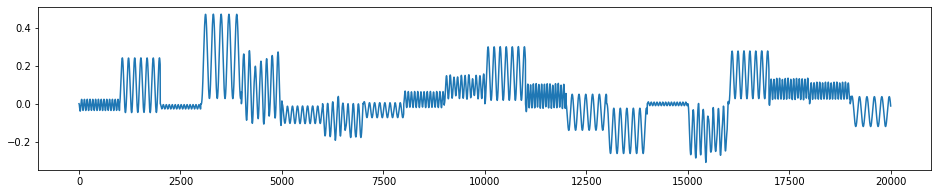

In [8]:
plt.figure(figsize=(16,3))
plt.plot(X[0].ravel())

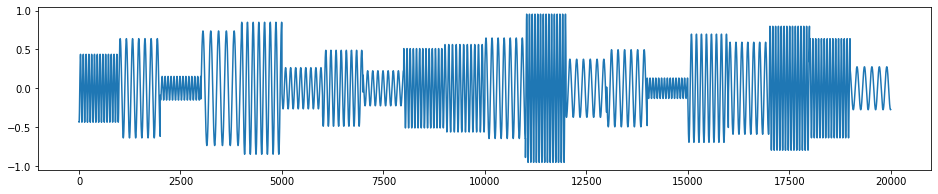

In [9]:
plt.figure(figsize=(16,3))
plt.plot(U[0].ravel())

## EDMD Predictor

In [10]:
num_rbfs = 100

In [11]:
class InverseQuadraticKernel(RadialBasisKernel):
    r"""Inverse quadratic radial basis kernel.

    .. math::
        K = (\frac{1}{2\varepsilon} \cdot D + 1)^{-1}

    where :math:`D` is the squared Euclidean distance matrix.

    See also super classes :class:`RadialBasisKernel` and :class:`PCManifoldKernel`
    for more functionality and documentation.

    Parameters
    ----------
    epsilon
        kernel scale
    """

    def __init__(self, epsilon: float = 1.0):
        self.epsilon = epsilon
        super(InverseQuadraticKernel, self).__init__(distance_metric="sqeuclidean")

    def eval(self, distance_matrix):
        """Evaluate the kernel on pre-computed distance matrix.

        Parameters
        ----------
        distance_matrix
            Matrix of pairwise distances of shape `(n_samples_Y, n_samples_X)`.

        Returns
        -------
        Union[np.ndarray, scipy.sparse.csr_matrix]
            Kernel matrix of same shape and type as `distance_matrix`.
        """

        self.epsilon = self._check_bandwidth_parameter(
            parameter=self.epsilon, name="epsilon"
        )

        return _apply_kernel_function_numexpr(
            distance_matrix,
            expr="1.0 / (1.0 / (2*eps) * D + 1.0)",
            expr_dict={"eps": self.epsilon},
        )

In [ ]:
rbf = TSCRadialBasis(kernel=InverseQuadraticKernel(epsilon=10),
                             center_type="fit_params")
center_ids = np.random.choice(range(0,sim_num_steps*training_size),size=num_rbfs,replace=False)
centers = XU.iloc[sorted(center_ids)].values
trans = rbf.fit_transform(XU, centers=centers)

In [12]:
rbf = TSCRadialBasis(kernel=InverseMultiquadricKernel(epsilon=.1),
                             center_type="initial_condition")
trans = rbf.fit_transform(TSCDataFrame.from_frame_list(Xlist))

In [13]:
trans

feature       rbf0      rbf1      rbf2      rbf3      rbf4      rbf5  \
ID time                                                                
0  0.00   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
   0.01   0.976047  0.976047  0.976047  0.976047  0.976047  0.976047   
   0.02   0.917768  0.917768  0.917768  0.917768  0.917768  0.917768   
   0.03   0.847018  0.847018  0.847018  0.847018  0.847018  0.847018   
   0.04   0.778664  0.778664  0.778664  0.778664  0.778664  0.778664   
...            ...       ...       ...       ...       ...       ...   
19 9.96   0.785568  0.785568  0.785568  0.785568  0.785568  0.785568   
   9.97   0.759010  0.759010  0.759010  0.759010  0.759010  0.759010   
   9.98   0.733240  0.733240  0.733240  0.733240  0.733240  0.733240   
   9.99   0.708859  0.708859  0.708859  0.708859  0.708859  0.708859   
   10.00  0.686249  0.686249  0.686249  0.686249  0.686249  0.686249   

feature       rbf6      rbf7      rbf8      rbf9     rbf10     rbf11  \
ID time                                                                
0  0.00   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
   0.01   0.976047  0.976047  0.976047  0.976047  0.976047  0.976047   
   0.02   0.917768  0.917768  0.917768  0.917768  0.917768  0.917768   
   0.03   0.847018  0.847018  0.847018  0.847018  0.847018  0.847018   
   0.04   0.778664  0.778664  0.778664  0.778664  0.778664  0.778664   
...            ...       ...       ...       ...       ...       ...   
19 9.96   0.785568  0.785568  0.785568  0.785568  0.785568  0.785568   
   9.97   0.759010  0.759010  0.759010  0.759010  0.759010  0.759010   
   9.98   0.733240  0.733240  0.733240  0.733240  0.733240  0.733240   
   9.99   0.708859  0.708859  0.708859  0.708859  0.708859  0.708859   
   10.00  0.686249  0.686249  0.686249  0.686249  0.686249  0.686249   

feature      rbf12     rbf13     rbf14     rbf15     rbf16     rbf17  \
ID time                                                                
0  0.00   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
   0.01   0.976047  0.976047  0.976047  0.976047  0.976047  0.976047   
   0.02   0.917768  0.917768  0.917768  0.917768  0.917768  0.917768   
   0.03   0.847018  0.847018  0.847018  0.847018  0.847018  0.847018   
   0.04   0.778664  0.778664  0.778664  0.778664  0.778664  0.778664   
...            ...       ...       ...       ...       ...       ...   
19 9.96   0.785568  0.785568  0.785568  0.785568  0.785568  0.785568   
   9.97   0.759010  0.759010  0.759010  0.759010  0.759010  0.759010   
   9.98   0.733240  0.733240  0.733240  0.733240  0.733240  0.733240   
   9.99   0.708859  0.708859  0.708859  0.708859  0.708859  0.708859   
   10.00  0.686249  0.686249  0.686249  0.686249  0.686249  0.686249   

feature      rbf18     rbf19  
ID time                       
0  0.00   1.000000  1.000000  
   0.01   0.976047  0.976047  
   0.02   0.917768  0.917768  
   0.03   0.847018  0.847018  
   0.04   0.778664  0.778664  
...            ...       ...  
19 9.96   0.785568  0.785568  
   9.97   0.759010  0.759010  
   9.98   0.733240  0.733240  
   9.99   0.708859  0.708859  
   10.00  0.686249  0.686249  

[20020 rows x 20 columns]

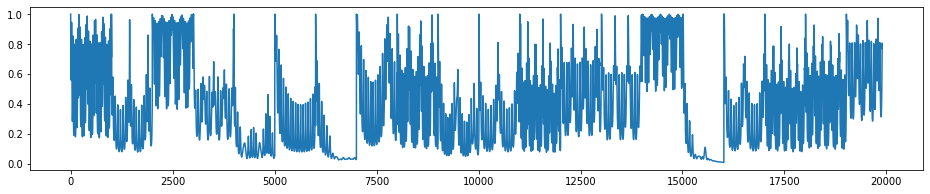

In [14]:
plt.figure(figsize=(16,3))
plt.plot(trans['rbf15'].values[:19900])

In [15]:
plt.figure(figsize=(16,3))
plt.plot(trans['rbf35'].values[20100:])

KeyError: 'rbf35'

<Figure size 1152x216 with 0 Axes>

In [16]:
dict_steps = [("rbf",
              TSCRadialBasis(kernel=InverseMultiquadricKernel(),
                             center_type="initial_condition"),)]
predictor = EDMD(dict_steps=dict_steps,include_id_state=True).fit(XU, dmd__store_system_matrix=True)

d:\documents\tum\hiwi\kmpc\datafold\datafold\dynfold\dmd.py:1187: UserWarning: Shift matrix (shape=(45, 45)) has not full rank (=13), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(


In [17]:
predictor.feature_names_out_

Index(['x', 'xdot', 'theta', 'thetadot', 'u', 'rbf0', 'rbf1', 'rbf2', 'rbf3',
       'rbf4', 'rbf5', 'rbf6', 'rbf7', 'rbf8', 'rbf9', 'rbf10', 'rbf11',
       'rbf12', 'rbf13', 'rbf14', 'rbf15', 'rbf16', 'rbf17', 'rbf18', 'rbf19',
       'rbf20', 'rbf21', 'rbf22', 'rbf23', 'rbf24', 'rbf25', 'rbf26', 'rbf27',
       'rbf28', 'rbf29', 'rbf30', 'rbf31', 'rbf32', 'rbf33', 'rbf34', 'rbf35',
       'rbf36', 'rbf37', 'rbf38', 'rbf39'],
      dtype='object', name='feature')

In [18]:
predictor.dmd_model.koopman_matrix_.shape

(45, 45)

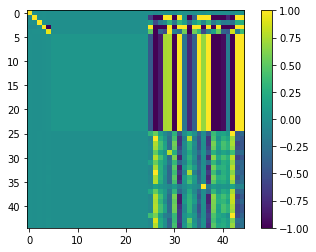

In [19]:
plt.imshow(predictor.dmd_model.koopman_matrix_, vmin=-1, vmax=1)
plt.colorbar()

In [20]:
prediction = predictor.predict(np.array([0,0,np.pi,0,1]))
prediction

feature              x          xdot      theta      thetadot         u
ID time                                                                
0  0.00  -5.592487e-16 -8.867773e-15   3.141593  1.667102e-14  1.000000
   0.01  -9.373598e-06 -1.816740e-03   3.134179 -1.485322e+00  0.934683
   0.02  -3.443423e-05 -3.128499e-03   3.112239 -2.904345e+00  0.872692
   0.03  -7.020713e-05 -3.950815e-03   3.076421 -4.259865e+00  0.813869
   0.04  -1.118711e-04 -4.298841e-03   3.027347 -5.554557e+00  0.758067
...                ...           ...        ...           ...       ...
   9.96   2.088555e-01  2.624179e-01 -11.559175  1.324319e+00  0.003282
   9.97   2.114847e-01  2.632788e-01 -11.545183  1.469233e+00  0.003281
   9.98   2.141215e-01  2.639403e-01 -11.529745  1.613578e+00  0.003279
   9.99   2.167640e-01  2.644013e-01 -11.512865  1.757354e+00  0.003276
   10.00  2.194100e-01  2.646609e-01 -11.494550  1.900562e+00  0.003273

[1001 rows x 5 columns]

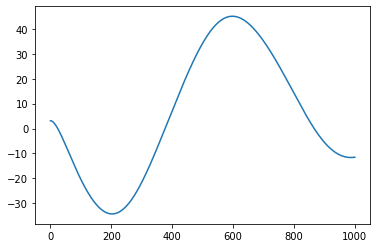

In [21]:
plt.plot(prediction['theta'].values)

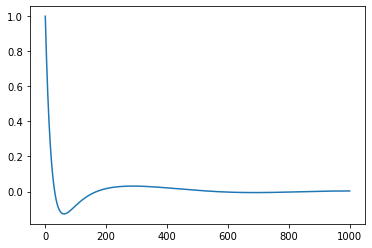

In [22]:
plt.plot(prediction['u'].values)

In [23]:
control_amplitude = 0.1 + 0.9*np.random.random() 
control_frequency = np.pi + 2*np.pi*np.random.random()
control_phase = 2*np.pi*np.random.random()
control_func = lambda t,y: control_amplitude*np.sin(control_frequency*t + control_phase)